# Valuation
This notebook explores how we can use Python commands to help evaluating the financial performance of a company. <br>
Contents: <br>
<ol>
    <li>Discounted Cash Flow Model</li>
    <li>Leveraged Buyout Model</li>
</ol>

In [1]:
# Import modules
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt

## 1. Discounted Cash Flow Model
$DCF = \frac{CF_1}{(1+r)^1}+\frac{CF_2}{(1+r)^2}+\frac{CF_3}{(1+r)^3}+...+\frac{CF_n}{(1+r)^n}$<br>
where $CF$ is cash flow and $r$ is the discount rate or 'weighted average cost of capital (WACC)'.

In [5]:
# Assume you have this cash flow. This would normally be imported from a CSV file, or from some remote server. 
# The data would also normally include headings, dates and other fields. We are generating this array for the purposes of illustrating
cash_flow = np.array([4680.00,1031.00,-853.00,1086.00,1355.00,215.00,-384.00,429.00,1744.00,956.00,2445.00,1643.00,6897.00])

# We assume a WACC of 23.97%%
rate = 0.2397

# To get the net present value:
npf.npv(rate=rate,values=cash_flow)

7577.326381029414

### Unlevered free cash flows

UFCF = $EBIT$x(1-$r$)+D&A+NWC-Capital expenditures <br>
<ol>
    <li>$EBIT$: Earnings before interest and taxes</li>
    <li>$r$: Effective tax rate (historical)</li>
    <li>D&A: Depreciation and amortization</li>
    <li>NWC: Annual changes in net working capital</li>
    <li>Capital expenditures: Cash investments required to sustain forecast growth of business</li>
</ol>

Assume 2021 has the following financials for Acme Pty Ltd:

In [6]:
dcf_data = {2021:{'EBITDA':19499,'Tax rate': 0.4003, 'D&A': 2523, 'NWC': -8470, 'Capital expenditures': -3.004}}
pd.DataFrame(dcf_data)

,2021
Capital expenditures,-3.0040
D&A,2523.0000
EBITDA,19499.0000
NWC,-8470.0000
Tax rate,0.4003


With the following projections:

In [7]:
for year in range(2022,2027):
    prev_data = dcf_data[year-1]
    dcf_data[year] = {'EBITDA':prev_data['EBITDA']*1.05,
                                    'Tax rate': prev_data['Tax rate'],
                                    'D&A': prev_data['D&A']*1.05,
                                    'NWC': prev_data['NWC']*0.9,
                                    'Capital expenditures': prev_data['Capital expenditures']*1.045}
dcf_df = pd.DataFrame(dcf_data).T
dcf_df.T

,2021,2022,2023,2024,2025,2026
EBITDA,19499.0000,20473.95000,21497.647500,22572.529875,23701.156369,24886.214187
Tax rate,0.4003,0.40030,0.400300,0.400300,0.400300,0.400300
D&A,2523.0000,2649.15000,2781.607500,2920.687875,3066.722269,3220.058382
NWC,-8470.0000,-7623.00000,-6860.700000,-6174.630000,-5557.167000,-5001.450300
Capital expenditures,-3.0040,-3.13918,-3.280443,-3.428063,-3.582326,-3.743531


To calculate UFCF:

In [9]:
dcf_df['EBIT'] = dcf_df.apply(lambda x: x['EBITDA']-x['D&A'],axis=1)
dcf_df['EBIT(1-t)'] = dcf_df.apply(lambda x: x['EBIT']*(1-x['Tax rate']),axis=1)
dcf_df['UFCF'] = dcf_df.apply(lambda x: sum(x[['EBIT(1-t)','D&A','NWC','Capital expenditures']]),axis=1)
dcf_df.T

,2021,2022,2023,2024,2025,2026
EBITDA,19499.0000,20473.95000,21497.647500,22572.529875,23701.156369,24886.214187
Tax rate,0.4003,0.40030,0.400300,0.400300,0.400300,0.400300
D&A,2523.0000,2649.15000,2781.607500,2920.687875,3066.722269,3220.058382
NWC,-8470.0000,-7623.00000,-6860.700000,-6174.630000,-5557.167000,-5001.450300
Capital expenditures,-3.0040,-3.13918,-3.280443,-3.428063,-3.582326,-3.743531
EBIT,16976.0000,17824.80000,18716.040000,19651.842000,20634.434100,21666.155805
EBIT(1-t),10180.5072,10689.53256,11224.009188,11785.209647,12374.470130,12993.193636
UFCF,4230.5032,5712.54338,7141.636245,8527.839459,9880.443073,11208.058188


In [10]:
discount_rate = 0.1
dcf_df['PV of UFCF'] = dcf_df.apply(lambda x: x['UFCF']/(1+discount_rate)**(x.name-2021),axis=1)
PV = dcf_df.loc[range(2022,2027)]['PV of UFCF'].sum()
print("Sum of present values",PV)

Sum of present values 31210.289857411306


### Terminal Value
<ol>
    <li>Growth in perpetuity</li>
    <li>EBITDA multiple</li>
</ol>

In [11]:
# 1. Growth in perpetuity
# State your long term growth rate:
growth_rate = 0.09
gterminal_value = dcf_df.loc[2026]['UFCF']*(1+growth_rate)/(discount_rate-growth_rate)
gpv_terminal_value = gterminal_value/(1+discount_rate)**(2026-2021)
print("Terminal Value", gterminal_value)
print("PV of Terminal Value", gpv_terminal_value)
print("Enterprise Value", PV+gpv_terminal_value)

Terminal Value 1221678.342481676
PV of Terminal Value 758566.1327664377
Enterprise Value 789776.422623849


In [12]:
# 2. EBITDA multiple
# EBITDA multiple value
ebitda_multiple = 9
eterminal_value = dcf_df.loc[2026]['EBITDA']*ebitda_multiple
epv_terminal_value = eterminal_value/(1+discount_rate)**(2026-2021)
print("Terminal Value", eterminal_value)
print("PV of Terminal Value", epv_terminal_value)
print("Enterprise Value", PV+epv_terminal_value)

Terminal Value 223975.92768468754
PV of Terminal Value 139071.4293513778
Enterprise Value 170281.71920878912


In [13]:
dcf_df.T

,2021,2022,2023,2024,2025,2026
EBITDA,19499.0000,20473.950000,21497.647500,22572.529875,23701.156369,24886.214187
Tax rate,0.4003,0.400300,0.400300,0.400300,0.400300,0.400300
D&A,2523.0000,2649.150000,2781.607500,2920.687875,3066.722269,3220.058382
NWC,-8470.0000,-7623.000000,-6860.700000,-6174.630000,-5557.167000,-5001.450300
Capital expenditures,-3.0040,-3.139180,-3.280443,-3.428063,-3.582326,-3.743531
EBIT,16976.0000,17824.800000,18716.040000,19651.842000,20634.434100,21666.155805
EBIT(1-t),10180.5072,10689.532560,11224.009188,11785.209647,12374.470130,12993.193636
UFCF,4230.5032,5712.543380,7141.636245,8527.839459,9880.443073,11208.058188
PV of UFCF,4230.5032,5193.221255,5902.178715,6407.092006,6748.475564,6959.322319


### Equity value
Net debt = Debt - assets and securities<br>
Dilutive shares outstanding = Basic shares outstanding + effect of dilutive securities<br>
Equity value = (PV of UFCF+PV of Terminal Value-Net debt)/Dilutive shares outstanding

# 2. Leveraged Buyout Model
Source: http://people.stern.nyu.edu/igiddy/spreadsheets/forestsforever.xls

In [14]:
# input
Input = {'Revenues':3600000,
         'Operating expenses': -2200000,
         'Growth rate':0.09,
         'Stable growth rate': 0.03,
         'Capital expenditures': 125000,
         'Depreciation': -100000,
         'Working capital change': 0.04,
         'Debt': 4500000,
         'Equity': 2,
         'Principal repayment': 300000,
         'Risk free rate': 0.045,
         'Market risk premium': 0.055,
         'New debt issued':0,
         'Tax rate': 0.35,
         'Target debt/equity ratio':1.30,
         'Rating':'B',
         'Credit spread':0.065,
         'New debt': 0,
         'Preferred dividends': 0,
         # Accumulate from previous year
         '_WACC': 1,
         '_Cost of equity': 1
         
        }
Input['Change in working capital'] = Input['Revenues']*Input['Working capital change']
initial_beta = 3.7
lbo = pd.DataFrame({})
#lbo = pd.DataFrame({'Year 1':Input})

In [15]:
def update_financials(curr_year,keep_betaul=True):
    """
    @param curr_year: pandas.Series
    @return updated pandas.Sers
    """
    curr_year = curr_year.copy()
    curr_year['EBIT'] = curr_year[['Revenues','Operating expenses','Depreciation']].sum()
    curr_year['Interest rate'] = curr_year[['Risk free rate','Credit spread']].sum()
    curr_year['Interest'] = -curr_year['Debt']*curr_year['Interest rate']
    curr_year['Tax'] = -curr_year['Tax rate']*curr_year[['EBIT','Interest']].sum()
    curr_year['Net income'] = curr_year[['EBIT','Interest','Tax']].sum()
    curr_year['EBITDA'] = curr_year['EBIT']-curr_year['Depreciation']
    curr_year['FCFF'] = curr_year['EBIT']*(1-curr_year['Tax rate'])-curr_year['Depreciation']-curr_year['Capital expenditures']-curr_year['Change in working capital']
    curr_year['Interest*(1-T)'] = curr_year['Debt'] * curr_year['Interest rate']*(1-curr_year['Tax rate'])
    curr_year['FCFE'] = curr_year['FCFF'] - curr_year['Interest*(1-T)'] - curr_year['Principal repayment'] + curr_year['New debt'] - curr_year['Preferred dividends']
    curr_year['Outstanding debt'] = curr_year['Debt']-curr_year['Principal repayment']+curr_year['New debt']
    curr_year['Outstanding equity'] = curr_year['Equity']+curr_year['Net income']
    curr_year['Total capitalization'] = curr_year['Outstanding debt']+curr_year['Outstanding equity']
    curr_year['D/E ratio'] = curr_year['Outstanding debt']/curr_year['Outstanding equity']
    ul_multiplier = 1+(1-curr_year['Tax rate'])*curr_year['D/E ratio']
    if not keep_betaul: curr_year['BetaUL'] = initial_beta/ul_multiplier
    curr_year['BetaL'] = ul_multiplier*curr_year['BetaUL']
    curr_year['Cost of equity'] = curr_year['Risk free rate']+curr_year['BetaL']*curr_year['Market risk premium']
    curr_year['Cost of debt'] = (curr_year['Risk free rate'] + curr_year['Credit spread'])*(1-curr_year['Tax rate'])
    curr_year['WACC'] = (curr_year['Cost of equity']+curr_year['Cost of debt']*curr_year['Target debt/equity ratio'])/(1+curr_year['Target debt/equity ratio'])
    # Accumulate from previous year
    curr_year['_WACC']*=(1+curr_year['WACC'])
    curr_year['_Cost of equity']*=(1+curr_year['Cost of equity'])
    curr_year['PV FCFF'] = curr_year['FCFF']/curr_year['_WACC']
    curr_year['PV FCFE'] = curr_year['FCFE']/curr_year['_Cost of equity']
    return curr_year
lbo = pd.DataFrame({})
# Calculate BetaUL for the first year, keep for the years to come
lbo['Year 1'] = update_financials(pd.Series(Input),False)
lbo

,Year 1
Revenues,3600000
Operating expenses,-2200000
Growth rate,0.09
Stable growth rate,0.03
Capital expenditures,125000
Depreciation,-100000
Working capital change,0.04
Debt,4500000
Equity,2
Principal repayment,300000


In [16]:
# Free Cash Flow
years_to_project = 6

# Changes on year
for i in range(2,years_to_project+1):
    curr_lbo = lbo['Year {0}'.format(i-1)].copy()
    curr_lbo.name = 'Year {0}'.format(i)
    if i == years_to_project:
        curr_lbo['Principal repayment'] = 0
        curr_lbo[['Revenues','Operating expenses',\
                  'Depreciation','Capital expenditures',\
                  'Change in working capital'
                 ]]*=(1+curr_lbo['Stable growth rate'])
    else:
        curr_lbo[['Revenues','Operating expenses',\
                  'Depreciation','Capital expenditures',\
                  'Change in working capital'
                 ]]*=(1+curr_lbo['Growth rate'])
    curr_lbo['Debt'] = curr_lbo['Outstanding debt']
    curr_lbo['Equity'] = curr_lbo['Outstanding equity']
    curr_lbo = update_financials(curr_lbo)
    lbo = pd.concat([lbo,curr_lbo],axis=1)
lbo

# Sum of changes
terminal_year = 'Year {0}'.format(years_to_project)
terminal_FCFF = lbo[terminal_year]['FCFF']/(lbo[terminal_year]['WACC']-lbo[terminal_year]['Growth rate'])
terminal_FCFE = terminal_FCFF - lbo[terminal_year]['Debt']
sum_PVFCFF = lbo.loc['PV FCFF'].sum()
sum_PVFCFE = lbo.loc['PV FCFE'].sum()

print('Free cash flow to Firm: {0}'.format(sum_PVFCFF))
print('Free cash flow to Equity: {0}'.format(sum_PVFCFE))
print('Weighted average cost of capital: {0}'.format(lbo[terminal_year]['WACC']))
print('Terminal value of equity: {0}'.format(terminal_FCFE))
print('Expect selling price after {0} years: {1}'.format(years_to_project, lbo[terminal_year][['Debt','Equity']].sum()))


Free cash flow to Firm: 3474339.1361934515
Free cash flow to Equity: 1035463.284992159
Weighted average cost of capital: 0.08014250901476518
Terminal value of equity: -102706512.02045082
Expect selling price after 6 years: 6662832.465450003


In [17]:
lbo

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6
Revenues,3600000,3924000.0,4277160.0,4662104.4,5081693.796,5234144.60988
Operating expenses,-2200000,-2398000.0,-2613820.0,-2849063.8,-3105479.542,-3198643.92826
Growth rate,0.09,0.09,0.09,0.09,0.09,0.09
Stable growth rate,0.03,0.03,0.03,0.03,0.03,0.03
Capital expenditures,125000,136250.0,148512.5,161878.625,176447.70125,181741.132288
Depreciation,-100000,-109000.0,-118810.0,-129502.9,-141158.161,-145392.90583
Working capital change,0.04,0.04,0.04,0.04,0.04,0.04
Debt,4500000,4200000,3900000,3600000,3300000,3000000
Equity,2,523252.0,1144002.0,1869096.5,2705996.005,3662832.46545
Principal repayment,300000,300000,300000,300000,300000,0


Text(0.5, 1.0, 'LBO Leverage Analysis')

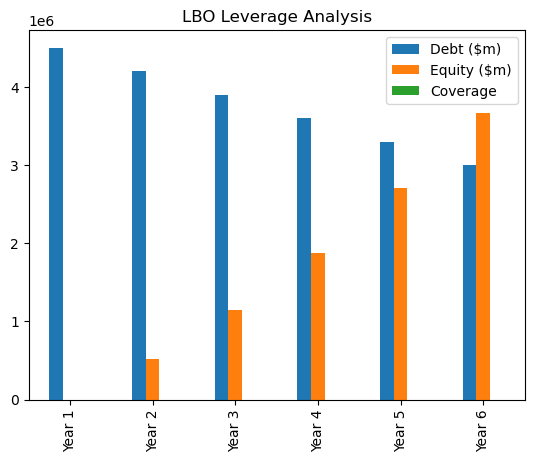

In [18]:
# Leverage 
lbo.loc['Coverage'] = lbo.apply(lambda x: -x['EBITDA']/x['Interest'])
lbo.loc['Debt ($m)'] = lbo.loc['Debt']/1
lbo.loc['Equity ($m)'] = lbo.loc['Equity']/1
lbo.T[['Debt ($m)','Equity ($m)','Coverage']].plot.bar()
plt.title('LBO Leverage Analysis')

Text(0.5, 1.0, 'Free cash flow analysis of LBO')

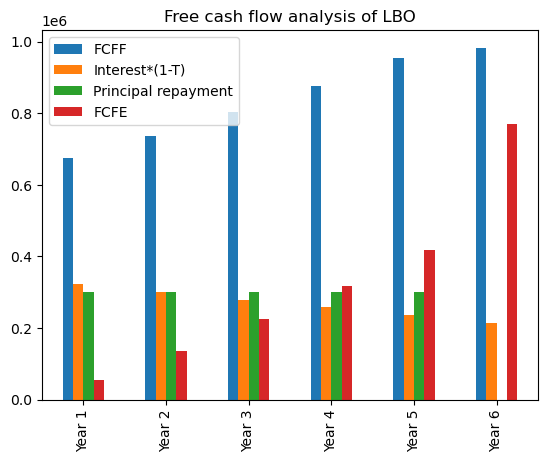

In [19]:
lbo.T[['FCFF','Interest*(1-T)','Principal repayment','FCFE']].plot.bar()
plt.title('Free cash flow analysis of LBO')

### Look-up table

In [20]:
is_inrange = lambda low,high,value: low<value and value<high

rating_table = {(-100000,0.5):('D',0.14),
                (0.5,0.8):('C',0.127),
                (0.8,1.25):('CC',0.115),
                (1.25,1.5):('CCC',0.10),
                (1.5,2.0):('B-',0.08),
                (2.0,2.5):('B',0.065),
                (2.5,3.0):('B+',0.048),
                (3.0,3.5):('BB',0.035),
                (3.5,4.0):('BBB',0.023),
                (4.5,6.0):('A-',0.020),
                (6.0,7.5):('A',0.018),
                (7.5,9.5):('A+',0.015),
                (9.5,12.5):('AA',0.010),
                (12.5,100000):('AAA',0.008)
               }
def get_rating_spread(coverage):
    """
    @param coverage: interest coverage ratio
    @return rating and spread
    """
    for low,high in rating_table:
        if is_inrange(low,high,coverage): 
            return rating_table[(low,high)]
get_rating_spread(0.3)


('D', 0.14)